In [5]:
import mne
import pandas
import numpy as np
import os
import matplotlib.pyplot as plt
import re



from mne import read_evokeds

# Initialization
Directory selection and reading the raw .edf files

In [8]:
def edfloader(directory, patient):
    os.chdir(directory)
        
    raw = mne.io.read_raw_edf(patient, eog=None, misc=None, 
                              stim_channel='auto', exclude=(), 
                              infer_types=False, preload=True, verbose=None)

    return raw

def remove_duplicate(raw):
    replace_dict = {}
    drop_list = []
    # for the channel names in the data...
    for channel_name in raw.info['ch_names']:
        # get the name to change too
        name_change = re.findall('\w+',channel_name)[0].title()
        # check if it is already in the change list
        if name_change in list(replace_dict.values()):
            drop_list.append(channel_name)
        else:
            # if its not already there get the origional name and what we want to 
            # change it to
            replace_dict[channel_name] = name_change

    # drop the ones that would be repeats
    raw.drop_channels(drop_list)
    # rename the channels
    raw.rename_channels(replace_dict)
    # set the standard montage
    montage =  mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, match_case=False)
    
    return raw

In [10]:
directory = "data/chb01"
patient = "chb01_03.edf"

raw = edfloader(directory, patient)
raw = remove_duplicate(raw)

Extracting EDF parameters from /zhome/ef/1/146924/Desktop/projects/epilepticseizures/data/chb01/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


/tmp/ipykernel_221530/3949993812.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(patient, eog=None, misc=None,


### Removing duplicates in the EEG signal

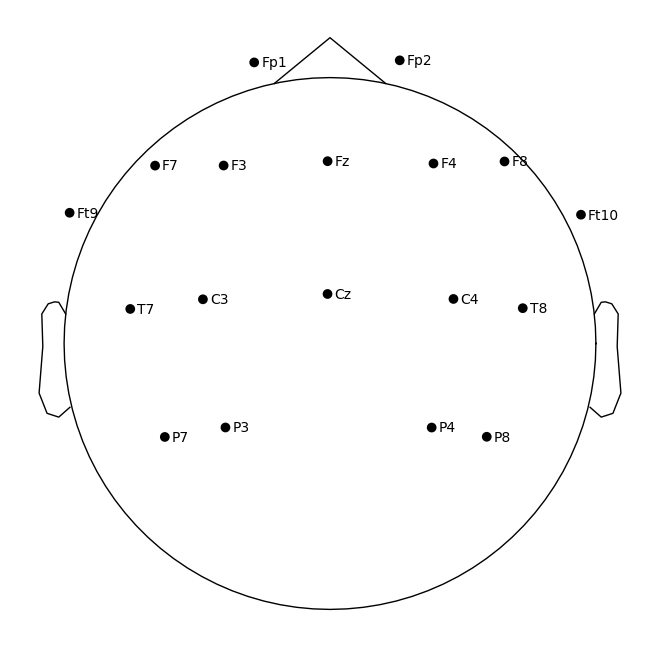

In [11]:
_ = raw.plot_sensors(kind='topomap', show_names=True, to_sphere=True)


In [12]:
def extract_seizure(raw, seizure_start, seizure_end):
    signal = []
    sample_size = 256
    n, elements = np.shape((raw[:])[0])
    for i in range(n):
        temp_signal = []
        temp_signal = raw[i][1][sample_size*seizure_start:sample_size*seizure_end]
        signal.append(temp_signal)
    
    signal = np.asarray(signal)
    return signal

In [13]:
# annotate seizure data
seizure_start = 2996 # in seconds
seizure_end = 3036
seizure_duration = seizure_end - seizure_start
annotation = mne.Annotations(onset=[0, seizure_start, seizure_end], 
                             duration=[seizure_start, seizure_duration, ((60*59)-seizure_end)], 
                             description=['Background', 'Seizure', 'Background'])
raw.set_annotations(annotation)
raw.annotations

<Annotations | 3 segments: Background (2), Seizure (1)>

In [14]:
selected_bands = [(1, 4, 'Delta'),
         (4, 8, 'Theta'),
         (8, 12, 'Alpha'),
         (12, 30, 'Beta'),
         (30, 127,'Gamma')] # Nyquest frequency is 128 Hz for 256 Hz samping rate, thus we can only see up to 127 Hz limit.

In [15]:
# plot parameters
plot_kwargs = {
    'scalings': dict(eeg=25e-5),   # zooms the plot out
    'show_scrollbars': False,
    'show': True
}

Using matplotlib as 2D backend.


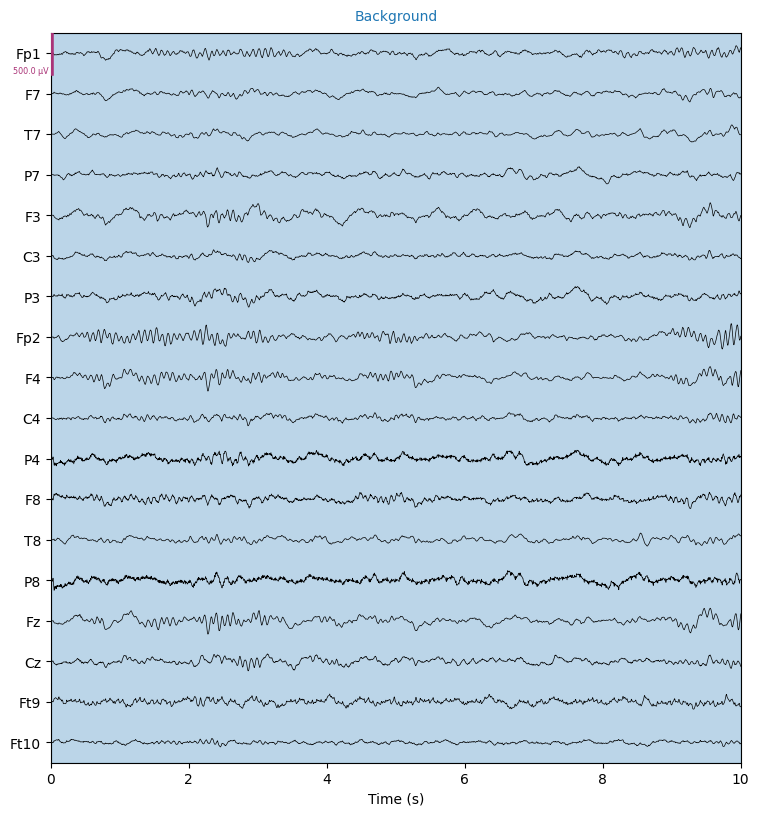

In [16]:
_ = raw.plot(start=0, duration=10, **plot_kwargs) # 10s preview


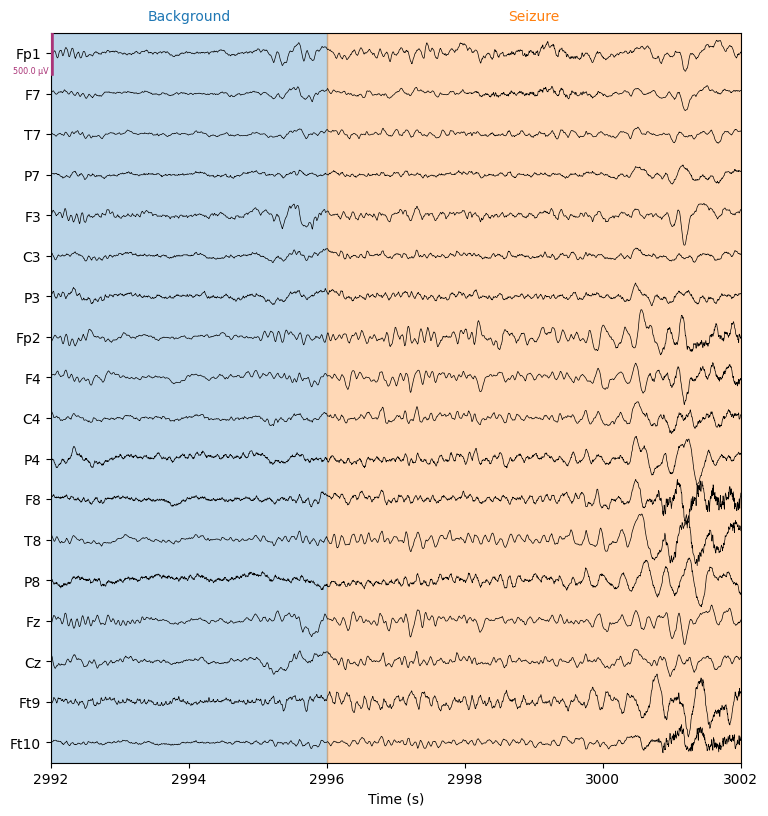

In [17]:
_ = raw.plot(start=seizure_start-4, duration=10, **plot_kwargs) # 4s before seizure start


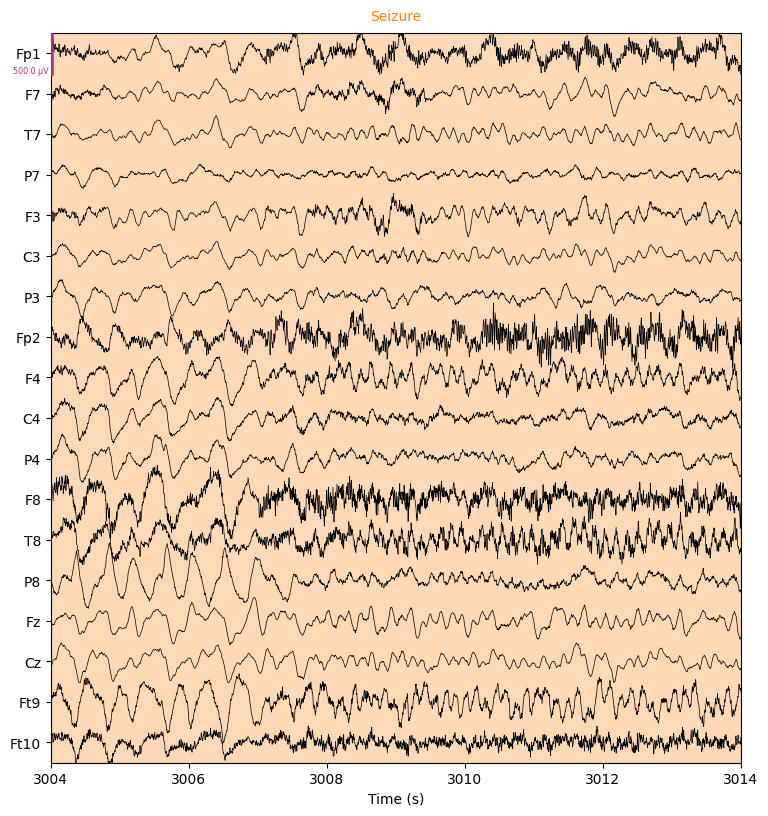

In [18]:
_ = raw.plot(start=seizure_start+8, duration=10, **plot_kwargs) # continued from above...


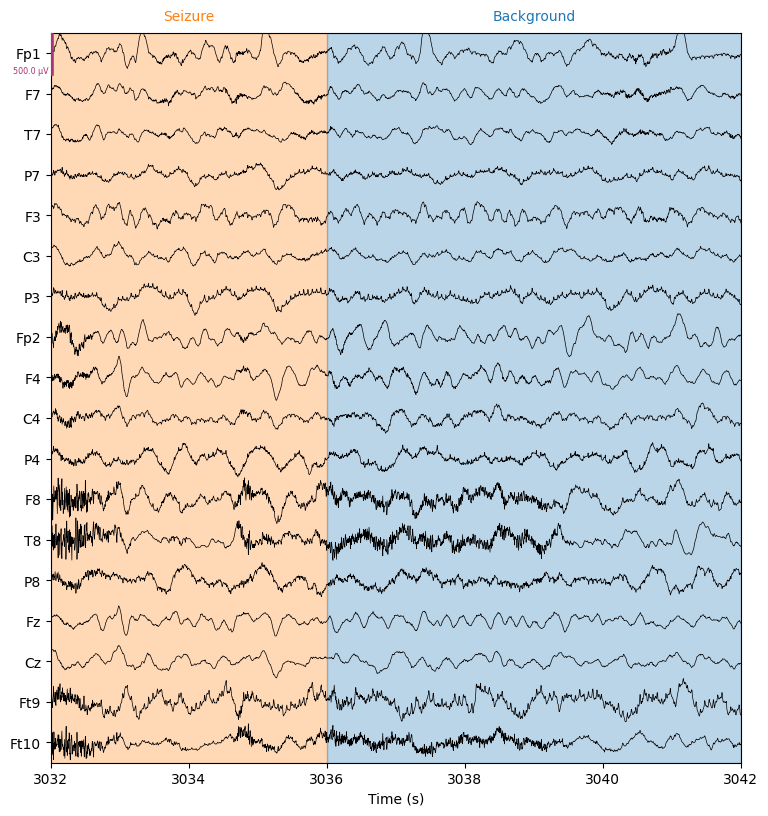

In [19]:
_ = raw.plot(start=seizure_end-4, duration=10, **plot_kwargs) # 4s before seizure ends


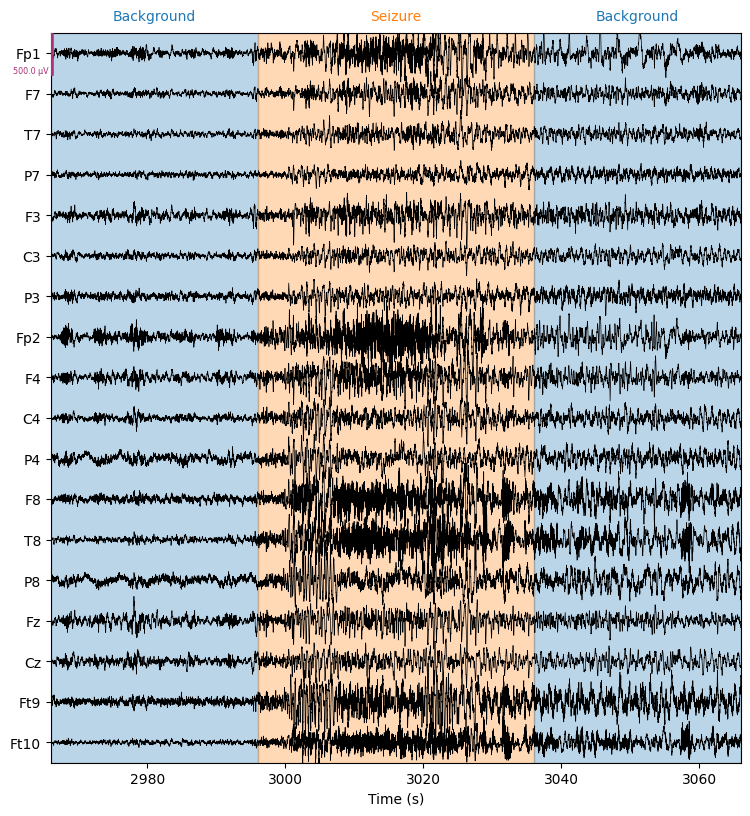

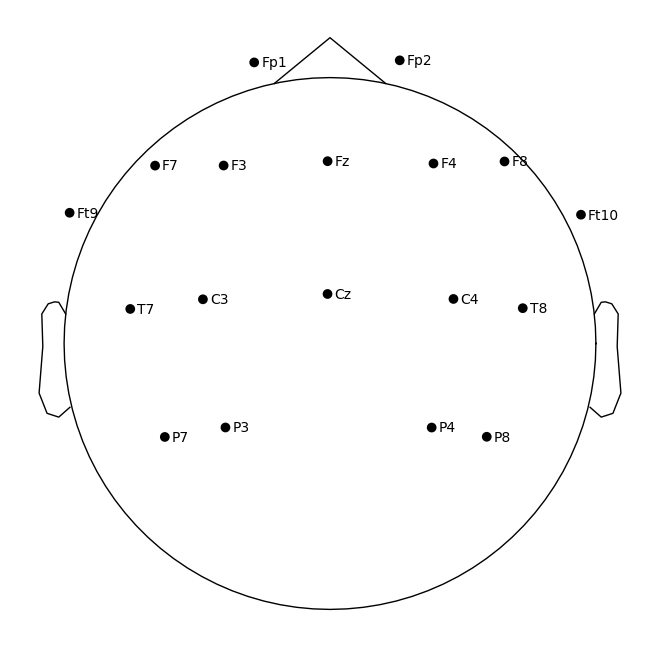

In [20]:
raw.plot(start=seizure_start-30, duration=seizure_duration+60, **plot_kwargs) # whole duration

_ = raw.plot_sensors(kind='topomap', show_names=True, to_sphere=True)


Fitting ICA to data using 18 channels (please be patient, this may take a while)


/tmp/ipykernel_221530/1852188713.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 18 components
Fitting ICA took 17.1s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1800 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1800 matching events found
No baseline correction applied
0 projection items activated


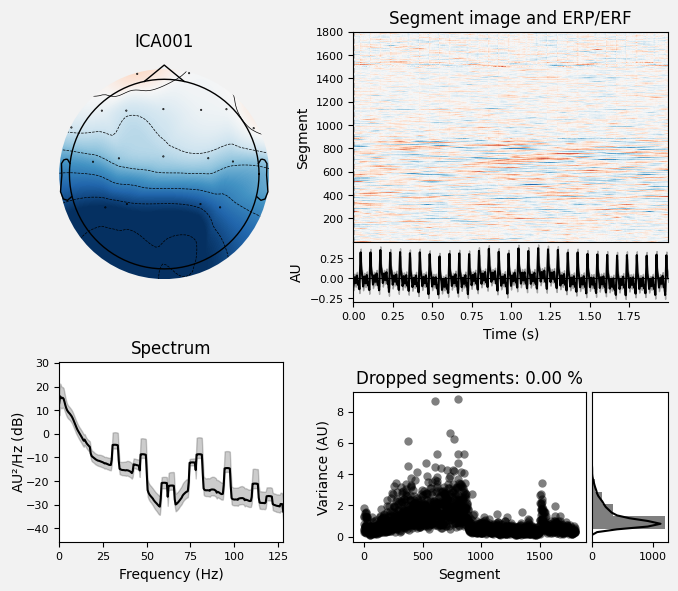

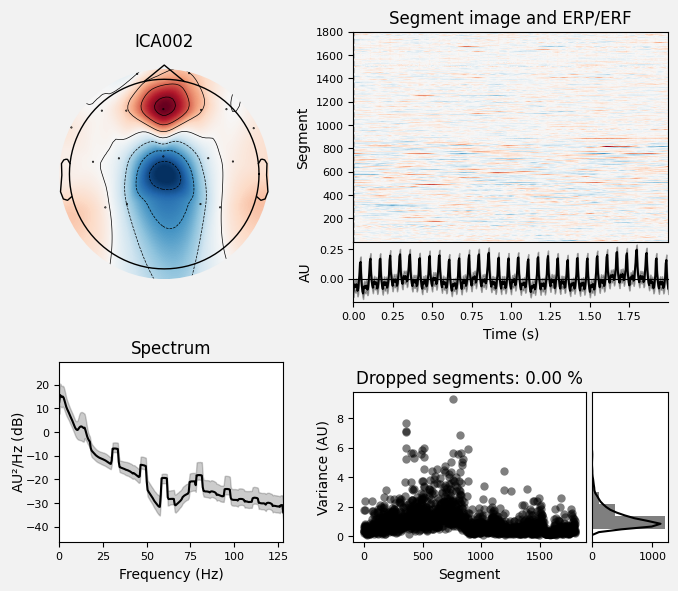

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [23]:
ica = mne.preprocessing.ICA(n_components=18, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude)

In [25]:
events = mne.find_events(raw, stim_channel='F7')
# we'll skip the "face" and "buttonpress" conditions to save memory
event_dict = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
              'visual/right': 4}
epochs = mne.Epochs(raw, events, tmin=-0.3, tmax=0.7, event_id=event_dict,
                    preload=True)
evoked = epochs['auditory/left'].average()

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
replace_dict

{'FP1-F7': 'Fp1',
 'F7-T7': 'F7',
 'T7-P7': 'T7',
 'P7-O1': 'P7',
 'F3-C3': 'F3',
 'C3-P3': 'C3',
 'P3-O1': 'P3',
 'FP2-F4': 'Fp2',
 'F4-C4': 'F4',
 'C4-P4': 'C4',
 'P4-O2': 'P4',
 'F8-T8': 'F8',
 'T8-P8-0': 'T8',
 'P8-O2': 'P8',
 'FZ-CZ': 'Fz',
 'CZ-PZ': 'Cz',
 'FT9-FT10': 'Ft9',
 'FT10-T8': 'Ft10'}

SyntaxError: invalid syntax (3360501298.py, line 1)

tilføjer en lille tekest
